In [101]:
!python3 -m spacy download en_core_web_sm > /dev/null 2>&1
!python3 -m spacy download pl_core_news_sm > /dev/null 2>&1

In [102]:
!pip uninstall -y cudf cuml dask-cudf rapids-dask-dependency apache-beam bigframes > /dev/null 2>&1

In [103]:
!pip install torch==2.0.1 torchvision==0.15.2 torchtext==0.15.2 datasets==2.14.7 evaluate==0.4.0 > /dev/null 2>&1
!pip install numpy==1.24.3 pandas==2.1.2 pyarrow==10.0.1 > /dev/null 2>&1

In [104]:
import os
import random
import tqdm
from dataclasses import dataclass
from datasets import DatasetDict

import pandas as pd
import numpy as np

import spacy
import en_core_web_sm
import pl_core_news_sm

import datasets
import torchtext

import torch
import torch.nn as nn
import torch.optim as optim

import evaluate

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import warnings
warnings.filterwarnings("ignore")

In [105]:
en_nlp = spacy.load("en_core_web_sm")  
pl_nlp = spacy.load("pl_core_news_sm") 

In [106]:
seed = 42

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [107]:
dataset = datasets.load_dataset('Helsinki-NLP/europarl', 'en-pl')
dataset

DatasetDict({
    train: Dataset({
        features: ['translation'],
        num_rows: 631160
    })
})

In [108]:
all_data = dataset["train"]
all_data = all_data.select(range(10000))
all_data[0]

train_test_split = all_data.train_test_split(test_size=0.2, seed=42)

train_data = train_test_split['train']
test_data = train_test_split['test']

print(f"Train size: {len(train_data)}, Test size: {len(test_data)}")

Train size: 8000, Test size: 2000


In [109]:
def tokenize_example(
    example,
    en_nlp,
    pl_nlp,
    max_length,
    lower,
    sos_token,
    eos_token
):
    '''
    Tokenizes a textual English-Polish input pair.
    Args:
        example: (dict) a dictionary with a nested key 'translation' containing 'en' and 'pl'.
        en_nlp: (spacy.lang) a spacy language model for English
        pl_nlp: (spacy.lang) a spacy language model for Polish
        max_length: (int) max input sentence length, symbols
        lower: (bool) if to lowercase input
        sos_token: (str) a start_of_sequence token
        eos_token: (str) an end_of_sequence token
    
    Returns:
        (dict) pre-processed and tokenized input sequences
    '''
    en_text = example["translation"]["en"]
    pl_text = example["translation"]["pl"]
    
    en_tokens = [token.text for token in en_nlp.tokenizer(en_text)][:max_length]
    pl_tokens = [token.text for token in pl_nlp.tokenizer(pl_text)][:max_length]
    
    if lower:
        en_tokens = [token.lower() for token in en_tokens]
        pl_tokens = [token.lower() for token in pl_tokens]
    
    en_tokens = [sos_token] + en_tokens + [eos_token]
    pl_tokens = [sos_token] + pl_tokens + [eos_token]
    
    return {"en_tokens": en_tokens, "pl_tokens": pl_tokens}

In [110]:
max_length = 1_000
lower = True
sos_token = "<sos>"
eos_token = "<eos>"

fn_kwargs = {
    "en_nlp": en_nlp, 
    "pl_nlp": pl_nlp, 
    "max_length": max_length,
    "lower": lower,
    "sos_token": sos_token,
    "eos_token": eos_token,
}

train_data = train_data.map(tokenize_example, fn_kwargs=fn_kwargs)
test_data = test_data.map(tokenize_example, fn_kwargs=fn_kwargs)

train_data[0]

{'translation': {'en': 'It is worried.', 'pl': 'Boją się.'},
 'en_tokens': ['<sos>', 'it', 'is', 'worried', '.', '<eos>'],
 'pl_tokens': ['<sos>', 'boją', 'się', '.', '<eos>']}

In [111]:
# Creating a vocab

min_freq = 2 # minimum frequency of occurrence in the text
unk_token = "<unk>" # unknown token
pad_token = "<pad>" # padding token

special_tokens = [
    unk_token,
    pad_token,
    sos_token,
    eos_token,
]

en_vocab = torchtext.vocab.build_vocab_from_iterator(
    train_data["en_tokens"],
    min_freq=min_freq,
    specials=special_tokens,
)

pl_vocab = torchtext.vocab.build_vocab_from_iterator(
    train_data["pl_tokens"],
    min_freq=min_freq,
    specials=special_tokens,  
)

assert en_vocab[unk_token] == pl_vocab[unk_token]
assert en_vocab[pad_token] == pl_vocab[pad_token]

unk_index = en_vocab[unk_token]
pad_index = en_vocab[pad_token]

print(unk_index)
print(pad_index)

print(en_vocab['the'])

0
1
4


In [112]:
en_vocab.set_default_index(unk_index)
pl_vocab.set_default_index(unk_index)

In [113]:
def numericalize_example(example, en_vocab, pl_vocab):
    '''
    Creates a mapping from string tokens to the vocabulary indexes.
    '''
    en_ids = en_vocab.lookup_indices(example["en_tokens"])
    pl_ids = pl_vocab.lookup_indices(example["pl_tokens"])
    return {"en_ids": en_ids, "pl_ids": pl_ids}

In [114]:
fn_kwargs = {
    "en_vocab": en_vocab, 
    "pl_vocab": pl_vocab
}

train_data = train_data.map(numericalize_example, fn_kwargs=fn_kwargs)
test_data = test_data.map(numericalize_example, fn_kwargs=fn_kwargs)

train_data[0]

{'translation': {'en': 'It is worried.', 'pl': 'Boją się.'},
 'en_tokens': ['<sos>', 'it', 'is', 'worried', '.', '<eos>'],
 'pl_tokens': ['<sos>', 'boją', 'się', '.', '<eos>'],
 'en_ids': [2, 20, 12, 2519, 6, 3],
 'pl_ids': [2, 0, 11, 5, 3]}

In [115]:
data_type = "torch"
format_columns = ["en_ids", "pl_ids"]

train_data = train_data.with_format(
    type=data_type, 
    columns=format_columns, 
    output_all_columns=True
)

test_data = test_data.with_format(
    type=data_type, 
    columns=format_columns, 
    output_all_columns=True,
)

train_data

Dataset({
    features: ['translation', 'en_tokens', 'pl_tokens', 'en_ids', 'pl_ids'],
    num_rows: 8000
})

In [116]:
def get_collate_fn(pad_index):
    '''
    Adding padding as a part of a collate_fn.
    '''
    
    def collate_fn(batch):
        batch_en_ids = [example["en_ids"] for example in batch]
        batch_pl_ids = [example["pl_ids"] for example in batch]
        batch_en_ids = nn.utils.rnn.pad_sequence(batch_en_ids, padding_value=pad_index)
        batch_pl_ids = nn.utils.rnn.pad_sequence(batch_pl_ids, padding_value=pad_index)
        batch = {
            "en_ids": batch_en_ids,
            "pl_ids": batch_pl_ids,
        }
        return batch
    
    return collate_fn

In [117]:
def get_data_loader(dataset, batch_size, pad_index, shuffle=False):
    
    collate_fn = get_collate_fn(pad_index)
    
    data_loader = torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        collate_fn=collate_fn,
        shuffle=shuffle,
    )
    
    return data_loader

In [118]:
batch_size = 16

train_data_loader = get_data_loader(train_data, batch_size, pad_index, shuffle=True)
test_data_loader = get_data_loader(test_data, batch_size, pad_index)

next(iter(train_data_loader))

{'en_ids': tensor([[   2,    2,    2,    2,    2,    2,    2,    2,    2,    2,    2,    2,
             2,    2,    2,    2],
         [  17,   19,  111,  145,  536,   18,  414,   14,    4,   60,  275,   60,
            16,   18,  108,   19],
         [  26, 3685,    5,  398,    7,   49,    6,    0,  143,   12,   32,   23,
           194,  154,    5, 1718],
         [ 309,   34,   60,   15,    4,   11,    3,   50,   65,   13, 3792,  157,
             7, 4047,   73,  438],
         [  19,  558,   12,    4,   94,    4,    1,    3,    7,  240,  129,  206,
             4,   10,   26,   40],
         [  10,  128,  752,  276,    3,   45,    1,    1,  202,  319, 1455,   16,
            67,  898, 1249,   24],
         [  13,    5,   11,   27,    1,    7,    1,    1,   14,   11,    9,    4,
           149,    6,   88,    5],
         [ 328,   38,   33, 5100,    1,    4,    1,    1,   19, 2023,  493, 1287,
             6,    3,    4,  111],
         [   7,   51,   57,   29,    1,   25,    1,   

In [119]:
class Encoder(nn.Module):
    def __init__(self, input_dim, embedding_dim, encoder_hidden_dim, decoder_hidden_dim):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.rnn = nn.GRU(embedding_dim, encoder_hidden_dim, bidirectional = True)
        self.fc = nn.Linear(encoder_hidden_dim * 2, decoder_hidden_dim)
        
    def forward(self, src): # (src_length, batch size)
        embedded = self.embedding(src) # (src_length, batch_size, embedding_dim)

        outputs, hidden = self.rnn(embedded)
        # outputs (src_length, batch_size, hidden dim * n_directions)
        # hidden (n_layers * n_directions, batch_size, hidden dim)
        
        # hidden is stacked [forward_1, backward_1, forward_2, backward_2, ...]
        
        # outputs are always from the last layer
        # hidden [-2, :, : ] is the last of the forwards RNN 
        # hidden [-1, :, : ] is the last of the backwards RNN
       
        # initial decoder hidden is final hidden state of the forwards and backwards 
        # encoder RNNs fed through a linear layer
        
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)))
        
        # outputs (src_length, batch_size, encoder_hidden_dim * 2)
        # hidden (batch_size, decoder_hidden_dim)
        
        return outputs, hidden

In [120]:
class Attention(nn.Module):
    def __init__(self, encoder_hidden_dim, decoder_hidden_dim):
        super().__init__()
        self.attn_fc = nn.Linear(
            (encoder_hidden_dim * 2) + decoder_hidden_dim, 
            decoder_hidden_dim
        )
        self.v_fc = nn.Linear(decoder_hidden_dim, 1, bias=False)
        
    def forward(self, hidden, encoder_outputs):        
        # hidden (batch_size, decoder_hidden_dim)
        # encoder_outputs (src_length, batch_size, encoder_hidden dim * 2)
        
        batch_size = encoder_outputs.shape[1]
        src_length = encoder_outputs.shape[0]
        
        # repeat decoder hidden state src_length times
        hidden = hidden.unsqueeze(1).repeat(1, src_length, 1) # (batch_size, src_length, decoder_hidden_dim)
        encoder_outputs = encoder_outputs.permute(1, 0, 2) # (batch_size, src_length, encoder_hidden_dim * 2)
        
        energy = torch.tanh(self.attn_fc(torch.cat((hidden, encoder_outputs), dim=2))) 
        # (batch_size, src_length, decoder_hidden_dim)

        attention = self.v_fc(energy).squeeze(2) # batch_size, src_length

        return torch.softmax(attention, dim=1)

In [121]:
class Decoder(nn.Module):
    def __init__(
        self,
        output_dim,
        embedding_dim,
        encoder_hidden_dim,
        decoder_hidden_dim,
        attention,
    ):
        super().__init__()
        self.output_dim = output_dim
        self.attention = attention
        self.embedding = nn.Embedding(output_dim, embedding_dim)
        self.rnn = nn.GRU((encoder_hidden_dim * 2) + embedding_dim, decoder_hidden_dim) 
        self.fc_out = nn.Linear(
            (encoder_hidden_dim * 2) + decoder_hidden_dim + embedding_dim, 
            output_dim
        )
        
    def forward(self, input, hidden, encoder_outputs):
        # input = (batch_size)
        # hidden = batch_size, decoder hidden dim]
        # encoder_outputs = [src length, batch size, encoder hidden dim * 2]
        input = input.unsqueeze(0)
        # input = [1, batch size]
        embedded = self.embedding(input)
        #embedded = [1, batch size, embedding dim]
        a = self.attention(hidden, encoder_outputs)
        # a = [batch size, src length]
        a = a.unsqueeze(1)
        # a = [batch size, 1, src length]
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        # encoder_outputs = [batch size, src length, encoder hidden dim * 2]
        weighted = torch.bmm(a, encoder_outputs) # batch matrix-matrix product
        # weighted = [batch size, 1, encoder hidden dim * 2]
        weighted = weighted.permute(1, 0, 2)
        # weighted = [1, batch size, encoder hidden dim * 2]
        rnn_input = torch.cat((embedded, weighted), dim = 2)
        # rnn_input = [1, batch size, (encoder hidden dim * 2) + embedding dim]
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
        # output = [seq length, batch size, decoder hid dim * n directions]
        # hidden = [n layers * n directions, batch size, decoder hid dim]
        # seq len, n layers and n directions will always be 1 in this decoder, therefore:
        # output = [1, batch size, decoder hidden dim]
        # hidden = [1, batch size, decoder hidden dim]
        # this also means that output == hidden
        assert (output == hidden).all()
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)
        prediction = self.fc_out(torch.cat((output, weighted, embedded), dim=1))
        #prediction = [batch size, output dim]
        return prediction, hidden.squeeze(0), a.squeeze(1)

In [122]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
    def forward(self, src, trg, teacher_forcing_ratio):
        # src = [src length, batch size]
        # trg = [trg length, batch size]
        # teacher_forcing_ratio is probability to use teacher forcing
        # e.g. if teacher_forcing_ratio is 0.75 we use teacher forcing 75% of the time
        batch_size = src.shape[1]
        trg_length = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        #tensor to store decoder outputs
        outputs = torch.zeros(trg_length, batch_size, trg_vocab_size).to(self.device)
        # encoder_outputs is all hidden states of the input sequence, back and forwards
        # hidden is the final forward and backward hidden states, passed through a linear layer
        encoder_outputs, hidden = self.encoder(src)
        # outputs = [src length, batch size, encoder hidden dim * 2]
        # hidden = [batch size, decoder hidden dim]
        # first input to the decoder is the <sos> tokens
        input = trg[0,:]
        for t in range(1, trg_length):
            # insert input token embedding, previous hidden state and all encoder hidden states
            # receive output tensor (predictions) and new hidden state
            output, hidden, _ = self.decoder(input, hidden, encoder_outputs)
            # output = [batch size, output dim]
            # hidden = [n layers, batch size, decoder hidden dim]
            #place predictions in a tensor holding predictions for each token
            outputs[t] = output
            #decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            #get the highest predicted token from our predictions
            top1 = output.argmax(1) 
            # if teacher forcing, use actual next token as next input
            # if not, use predicted token
            input = trg[t] if teacher_force else top1
            # input = [batch size]
        return outputs

In [123]:
input_dim = len(pl_vocab)
output_dim = len(en_vocab)
encoder_embedding_dim = 256
decoder_embedding_dim = 256
encoder_hidden_dim = 512
decoder_hidden_dim = 512
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_dir = './saved_models'

In [124]:
attention = Attention(encoder_hidden_dim, decoder_hidden_dim)

encoder = Encoder(
    input_dim,
    encoder_embedding_dim,
    encoder_hidden_dim,
    decoder_hidden_dim
)

decoder = Decoder(
    output_dim,
    decoder_embedding_dim,
    encoder_hidden_dim,
    decoder_hidden_dim,
    attention,
)

model = Seq2Seq(encoder, decoder, device).to(device)

model

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(9839, 256)
    (rnn): GRU(256, 512, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn_fc): Linear(in_features=1536, out_features=512, bias=True)
      (v_fc): Linear(in_features=512, out_features=1, bias=False)
    )
    (embedding): Embedding(5700, 256)
    (rnn): GRU(1280, 512)
    (fc_out): Linear(in_features=1792, out_features=5700, bias=True)
  )
)

In [125]:
def init_weights(m):
    """
    Initiates model weights from the normal distribution.
    Sets bias to 0.
    """
    for name, param in m.named_parameters():
        if "weight" in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)
            
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(9839, 256)
    (rnn): GRU(256, 512, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn_fc): Linear(in_features=1536, out_features=512, bias=True)
      (v_fc): Linear(in_features=512, out_features=1, bias=False)
    )
    (embedding): Embedding(5700, 256)
    (rnn): GRU(1280, 512)
    (fc_out): Linear(in_features=1792, out_features=5700, bias=True)
  )
)

In [126]:
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=pad_index)

In [127]:
def train_fn(model, data_loader, optimizer, criterion, clip, teacher_forcing_ratio, device):
    model.train()
    epoch_loss = 0
    for i, batch in tqdm.tqdm(enumerate(data_loader)): #changed
        src = batch["pl_ids"].to(device)
        trg = batch["en_ids"].to(device)
        # src = [src length, batch size]
        # trg = [trg length, batch size]
        optimizer.zero_grad()
        output = model(src, trg, teacher_forcing_ratio)
        # output = [trg length, batch size, trg vocab size]
        output_dim = output.shape[-1]
        output = output[1:].view(-1, output_dim)
        # output = [(trg length - 1) * batch size, trg vocab size]
        trg = trg[1:].view(-1)
        # trg = [(trg length - 1) * batch size]
        loss = criterion(output, trg)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(data_loader)

def evaluate_fn(model, data_loader, criterion, device):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for i, batch in enumerate(data_loader):
            src = batch["pl_ids"].to(device)
            trg = batch["en_ids"].to(device)
            # src = [src length, batch size]
            # trg = [trg length, batch size]
            output = model(src, trg, 0) #turn off teacher forcing
            # output = [trg length, batch size, trg vocab size]
            output_dim = output.shape[-1]
            output = output[1:].view(-1, output_dim)
            # output = [(trg length - 1) * batch size, trg vocab size]
            trg = trg[1:].view(-1)
            # trg = [(trg length - 1) * batch size]
            loss = criterion(output, trg)
            epoch_loss += loss.item()
    return epoch_loss / len(data_loader)


In [128]:
n_epochs = 10
clip = 1.0 # gradient clipping
teacher_forcing_ratio = 0.5

best_valid_loss = float("inf")

for epoch in tqdm.tqdm(range(n_epochs)):
        
    train_loss = train_fn(
        model, 
        train_data_loader, 
        optimizer, 
        criterion, 
        clip, 
        teacher_forcing_ratio, 
        device,
    )
    
    test_loss = evaluate_fn(
        model, 
        test_data_loader, 
        criterion, 
        device,
    )

    if test_loss < best_valid_loss:
        best_valid_loss = test_loss
        os.makedirs(model_dir, exist_ok=True) # added
        torch.save(model.state_dict(), os.path.join(model_dir, 'en_pl.pt'))
    
    print(f"\\tTrain Loss: {train_loss:7.3f}")
    print(f"\\tTest Loss: {test_loss:7.3f}")

  0%|          | 0/10 [00:00<?, ?it/s]
0it [00:00, ?it/s]
1it [00:00,  2.09it/s]
2it [00:00,  3.11it/s]
3it [00:00,  3.18it/s]
4it [00:01,  3.01it/s]
5it [00:01,  3.23it/s]
6it [00:02,  2.35it/s]
7it [00:02,  2.21it/s]
8it [00:02,  2.66it/s]
9it [00:03,  2.64it/s]
10it [00:03,  2.93it/s]
11it [00:03,  3.53it/s]
12it [00:03,  4.01it/s]
13it [00:04,  4.41it/s]
14it [00:04,  4.50it/s]
15it [00:04,  3.67it/s]
16it [00:05,  3.32it/s]
17it [00:05,  3.54it/s]
18it [00:05,  3.99it/s]
19it [00:05,  3.99it/s]
20it [00:06,  3.62it/s]
21it [00:06,  3.90it/s]
22it [00:06,  3.53it/s]
23it [00:06,  3.66it/s]
24it [00:07,  3.79it/s]
25it [00:07,  4.09it/s]
26it [00:07,  4.17it/s]
27it [00:07,  3.63it/s]
28it [00:08,  3.41it/s]
29it [00:08,  3.92it/s]
30it [00:08,  4.19it/s]
31it [00:08,  3.75it/s]
32it [00:09,  3.96it/s]
33it [00:09,  4.54it/s]
34it [00:09,  4.30it/s]
35it [00:09,  4.55it/s]
36it [00:10,  4.34it/s]
37it [00:10,  4.06it/s]
38it [00:10,  4.02it/s]
39it [00:10,  3.68it/s]
40it [00:11,  4

\tTrain Loss:   5.835
\tTest Loss:   5.742



0it [00:00, ?it/s]
1it [00:00,  3.41it/s]
2it [00:00,  3.56it/s]
3it [00:00,  4.19it/s]
4it [00:00,  5.02it/s]
5it [00:01,  4.93it/s]
6it [00:01,  4.72it/s]
7it [00:01,  4.86it/s]
8it [00:01,  4.86it/s]
9it [00:01,  4.84it/s]
10it [00:02,  4.14it/s]
11it [00:02,  3.63it/s]
12it [00:02,  4.33it/s]
13it [00:02,  4.61it/s]
14it [00:03,  4.82it/s]
15it [00:03,  4.20it/s]
16it [00:03,  4.40it/s]
17it [00:03,  5.08it/s]
18it [00:04,  3.96it/s]
19it [00:04,  4.17it/s]
20it [00:04,  4.42it/s]
21it [00:04,  4.00it/s]
22it [00:05,  4.04it/s]
23it [00:05,  3.22it/s]
24it [00:05,  3.89it/s]
25it [00:05,  4.21it/s]
26it [00:06,  4.50it/s]
27it [00:06,  4.43it/s]
28it [00:06,  4.03it/s]
29it [00:06,  4.47it/s]
30it [00:07,  3.74it/s]
31it [00:07,  2.64it/s]
32it [00:07,  3.04it/s]
33it [00:08,  3.55it/s]
34it [00:08,  3.61it/s]
35it [00:08,  3.21it/s]
36it [00:09,  3.41it/s]
37it [00:09,  3.43it/s]
38it [00:09,  3.61it/s]
39it [00:09,  3.21it/s]
40it [00:10,  3.24it/s]
41it [00:10,  2.90it/s]
42it 

\tTrain Loss:   5.095
\tTest Loss:   5.524



0it [00:00, ?it/s]
1it [00:00,  5.82it/s]
2it [00:00,  6.11it/s]
3it [00:00,  5.49it/s]
4it [00:00,  5.71it/s]
5it [00:01,  3.63it/s]
6it [00:01,  3.97it/s]
7it [00:01,  3.50it/s]
8it [00:01,  3.77it/s]
9it [00:02,  4.16it/s]
10it [00:02,  4.17it/s]
11it [00:02,  4.50it/s]
12it [00:02,  4.83it/s]
13it [00:02,  4.59it/s]
14it [00:03,  4.43it/s]
15it [00:03,  4.12it/s]
16it [00:03,  4.52it/s]
17it [00:03,  4.63it/s]
18it [00:04,  4.92it/s]
19it [00:04,  5.07it/s]
20it [00:04,  4.64it/s]
21it [00:04,  3.91it/s]
22it [00:05,  4.06it/s]
23it [00:05,  3.95it/s]
24it [00:05,  4.15it/s]
25it [00:05,  3.32it/s]
26it [00:06,  3.60it/s]
27it [00:06,  3.95it/s]
28it [00:06,  3.88it/s]
29it [00:06,  3.63it/s]
30it [00:07,  4.28it/s]
31it [00:07,  3.83it/s]
32it [00:07,  4.29it/s]
33it [00:07,  3.93it/s]
34it [00:08,  4.53it/s]
35it [00:08,  4.68it/s]
36it [00:08,  4.77it/s]
37it [00:08,  4.72it/s]
38it [00:08,  4.16it/s]
39it [00:09,  4.21it/s]
40it [00:09,  4.19it/s]
41it [00:09,  4.46it/s]
42it 

\tTrain Loss:   4.598
\tTest Loss:   5.296



0it [00:00, ?it/s]
1it [00:00,  5.90it/s]
2it [00:00,  5.30it/s]
3it [00:00,  4.33it/s]
4it [00:00,  4.12it/s]
5it [00:01,  4.15it/s]
6it [00:01,  4.60it/s]
7it [00:01,  4.67it/s]
8it [00:01,  3.70it/s]
9it [00:02,  3.77it/s]
10it [00:02,  4.32it/s]
11it [00:02,  4.48it/s]
12it [00:02,  4.23it/s]
13it [00:03,  3.40it/s]
14it [00:03,  3.43it/s]
15it [00:03,  3.54it/s]
16it [00:04,  3.77it/s]
17it [00:04,  4.01it/s]
18it [00:04,  4.18it/s]
19it [00:04,  4.97it/s]
20it [00:04,  4.94it/s]
21it [00:04,  4.85it/s]
22it [00:05,  4.30it/s]
23it [00:05,  4.46it/s]
24it [00:05,  4.97it/s]
25it [00:05,  4.72it/s]
26it [00:06,  4.60it/s]
27it [00:06,  4.54it/s]
28it [00:06,  3.84it/s]
29it [00:06,  4.07it/s]
30it [00:07,  3.61it/s]
31it [00:07,  3.85it/s]
32it [00:07,  3.82it/s]
33it [00:07,  4.11it/s]
34it [00:08,  4.38it/s]
35it [00:08,  4.21it/s]
36it [00:08,  3.67it/s]
37it [00:08,  3.88it/s]
38it [00:09,  3.94it/s]
39it [00:09,  4.19it/s]
40it [00:09,  4.62it/s]
41it [00:09,  4.54it/s]
42it 

\tTrain Loss:   4.111
\tTest Loss:   5.165



0it [00:00, ?it/s]
1it [00:00,  3.73it/s]
2it [00:00,  4.75it/s]
3it [00:00,  4.06it/s]
4it [00:00,  4.03it/s]
5it [00:01,  3.72it/s]
6it [00:01,  4.50it/s]
7it [00:01,  4.59it/s]
8it [00:01,  3.75it/s]
9it [00:02,  4.21it/s]
10it [00:02,  3.92it/s]
11it [00:02,  4.01it/s]
12it [00:03,  3.29it/s]
13it [00:03,  3.30it/s]
14it [00:03,  3.19it/s]
15it [00:03,  3.60it/s]
16it [00:04,  3.90it/s]
17it [00:04,  3.90it/s]
18it [00:04,  4.00it/s]
19it [00:04,  3.84it/s]
20it [00:05,  4.29it/s]
21it [00:05,  3.93it/s]
22it [00:05,  4.41it/s]
23it [00:05,  4.54it/s]
24it [00:06,  4.33it/s]
25it [00:06,  3.20it/s]
26it [00:06,  3.68it/s]
27it [00:07,  3.61it/s]
28it [00:07,  3.37it/s]
29it [00:07,  3.58it/s]
30it [00:07,  3.77it/s]
31it [00:08,  4.19it/s]
32it [00:08,  4.08it/s]
33it [00:08,  4.15it/s]
34it [00:08,  3.97it/s]
35it [00:08,  4.12it/s]
36it [00:09,  4.54it/s]
37it [00:09,  4.44it/s]
38it [00:09,  3.44it/s]
39it [00:10,  3.30it/s]
40it [00:10,  3.59it/s]
41it [00:10,  3.49it/s]
42it 

\tTrain Loss:   3.598
\tTest Loss:   5.145



0it [00:00, ?it/s]
1it [00:00,  3.87it/s]
2it [00:00,  3.54it/s]
3it [00:00,  4.29it/s]
4it [00:00,  4.46it/s]
5it [00:01,  4.71it/s]
6it [00:01,  5.10it/s]
7it [00:01,  5.11it/s]
8it [00:01,  3.64it/s]
9it [00:02,  3.86it/s]
10it [00:02,  3.76it/s]
11it [00:02,  3.77it/s]
12it [00:02,  4.12it/s]
13it [00:03,  3.87it/s]
14it [00:03,  4.25it/s]
15it [00:03,  4.49it/s]
16it [00:03,  4.75it/s]
17it [00:03,  4.60it/s]
18it [00:04,  3.85it/s]
19it [00:04,  3.66it/s]
20it [00:04,  4.12it/s]
21it [00:05,  4.19it/s]
22it [00:05,  4.67it/s]
23it [00:05,  4.40it/s]
24it [00:05,  4.85it/s]
25it [00:05,  4.61it/s]
26it [00:06,  4.09it/s]
27it [00:06,  4.37it/s]
28it [00:06,  3.57it/s]
29it [00:07,  3.70it/s]
30it [00:07,  3.80it/s]
31it [00:07,  3.93it/s]
32it [00:07,  3.56it/s]
33it [00:08,  3.84it/s]
34it [00:08,  3.78it/s]
35it [00:08,  4.01it/s]
36it [00:09,  3.16it/s]
37it [00:09,  3.20it/s]
38it [00:09,  3.52it/s]
39it [00:09,  3.64it/s]
40it [00:10,  3.87it/s]
41it [00:10,  3.97it/s]
42it 

\tTrain Loss:   3.081
\tTest Loss:   5.285



0it [00:00, ?it/s]
1it [00:00,  3.53it/s]
2it [00:00,  3.77it/s]
3it [00:00,  4.30it/s]
4it [00:00,  4.26it/s]
5it [00:01,  4.56it/s]
6it [00:01,  4.03it/s]
7it [00:01,  4.01it/s]
8it [00:01,  4.07it/s]
9it [00:02,  4.67it/s]
10it [00:02,  4.97it/s]
11it [00:02,  4.95it/s]
12it [00:02,  4.86it/s]
13it [00:02,  4.23it/s]
14it [00:03,  4.26it/s]
15it [00:03,  4.39it/s]
16it [00:03,  3.92it/s]
17it [00:03,  4.32it/s]
18it [00:04,  4.10it/s]
19it [00:04,  4.13it/s]
20it [00:04,  4.55it/s]
21it [00:04,  4.71it/s]
22it [00:05,  3.97it/s]
23it [00:05,  3.65it/s]
24it [00:05,  3.23it/s]
25it [00:06,  3.10it/s]
26it [00:06,  2.99it/s]
27it [00:06,  3.34it/s]
28it [00:07,  3.28it/s]
29it [00:07,  3.98it/s]
30it [00:07,  3.94it/s]
31it [00:07,  3.60it/s]
32it [00:08,  3.94it/s]
33it [00:08,  3.14it/s]
34it [00:08,  3.58it/s]
35it [00:08,  3.93it/s]
36it [00:09,  3.35it/s]
37it [00:09,  3.41it/s]
38it [00:09,  3.67it/s]
39it [00:10,  3.90it/s]
40it [00:10,  4.31it/s]
41it [00:10,  3.80it/s]
42it 

\tTrain Loss:   2.644
\tTest Loss:   5.349



0it [00:00, ?it/s]
1it [00:00,  3.57it/s]
2it [00:00,  3.16it/s]
3it [00:00,  3.82it/s]
4it [00:01,  4.14it/s]
5it [00:01,  4.13it/s]
6it [00:01,  4.36it/s]
7it [00:01,  3.53it/s]
8it [00:02,  3.71it/s]
9it [00:02,  4.07it/s]
10it [00:02,  4.29it/s]
11it [00:02,  3.71it/s]
12it [00:03,  3.70it/s]
13it [00:03,  4.03it/s]
14it [00:03,  3.46it/s]
15it [00:04,  3.42it/s]
16it [00:04,  3.71it/s]
17it [00:04,  4.02it/s]
18it [00:04,  3.87it/s]
19it [00:04,  4.12it/s]
20it [00:05,  4.53it/s]
21it [00:05,  4.57it/s]
22it [00:05,  4.59it/s]
23it [00:05,  4.70it/s]
24it [00:06,  4.08it/s]
25it [00:06,  4.35it/s]
26it [00:06,  4.05it/s]
27it [00:06,  4.04it/s]
28it [00:07,  2.94it/s]
29it [00:07,  3.07it/s]
30it [00:07,  3.03it/s]
31it [00:08,  3.12it/s]
32it [00:08,  3.45it/s]
33it [00:08,  3.53it/s]
34it [00:09,  3.61it/s]
35it [00:09,  3.94it/s]
36it [00:09,  4.10it/s]
37it [00:09,  4.18it/s]
38it [00:10,  3.66it/s]
39it [00:10,  3.03it/s]
40it [00:10,  3.14it/s]
41it [00:10,  3.59it/s]
42it 

\tTrain Loss:   2.327
\tTest Loss:   5.512



0it [00:00, ?it/s]
1it [00:00,  2.86it/s]
2it [00:00,  3.52it/s]
3it [00:00,  3.76it/s]
4it [00:01,  4.06it/s]
5it [00:01,  4.66it/s]
6it [00:01,  4.41it/s]
7it [00:01,  4.11it/s]
8it [00:01,  4.10it/s]
9it [00:02,  4.63it/s]
10it [00:02,  4.54it/s]
11it [00:02,  5.23it/s]
12it [00:02,  5.47it/s]
13it [00:02,  5.60it/s]
14it [00:03,  4.75it/s]
15it [00:03,  5.19it/s]
16it [00:03,  5.37it/s]
17it [00:03,  5.00it/s]
18it [00:03,  4.92it/s]
19it [00:04,  4.90it/s]
20it [00:04,  4.36it/s]
21it [00:04,  4.65it/s]
22it [00:04,  3.72it/s]
23it [00:05,  3.53it/s]
24it [00:05,  3.45it/s]
25it [00:05,  3.96it/s]
26it [00:05,  4.26it/s]
27it [00:06,  4.60it/s]
28it [00:06,  3.92it/s]
29it [00:06,  3.78it/s]
30it [00:07,  3.14it/s]
31it [00:07,  3.24it/s]
32it [00:07,  3.59it/s]
33it [00:07,  3.67it/s]
34it [00:08,  3.48it/s]
35it [00:08,  3.61it/s]
36it [00:08,  3.90it/s]
37it [00:09,  3.67it/s]
38it [00:09,  4.16it/s]
39it [00:09,  3.60it/s]
40it [00:09,  3.61it/s]
41it [00:09,  4.09it/s]
42it 

\tTrain Loss:   2.078
\tTest Loss:   5.622



0it [00:00, ?it/s]
1it [00:00,  3.30it/s]
2it [00:00,  4.11it/s]
3it [00:00,  3.97it/s]
4it [00:00,  4.46it/s]
5it [00:01,  4.99it/s]
6it [00:01,  4.49it/s]
7it [00:01,  4.88it/s]
8it [00:01,  4.35it/s]
9it [00:02,  4.03it/s]
10it [00:02,  4.59it/s]
11it [00:02,  4.55it/s]
12it [00:02,  4.93it/s]
13it [00:02,  4.58it/s]
14it [00:03,  4.15it/s]
15it [00:03,  4.03it/s]
16it [00:03,  4.40it/s]
17it [00:03,  4.38it/s]
18it [00:04,  4.20it/s]
19it [00:04,  3.75it/s]
20it [00:04,  3.85it/s]
21it [00:04,  4.19it/s]
22it [00:05,  4.71it/s]
23it [00:05,  4.77it/s]
24it [00:05,  4.84it/s]
25it [00:05,  4.49it/s]
26it [00:06,  3.87it/s]
27it [00:06,  4.19it/s]
28it [00:06,  4.54it/s]
29it [00:06,  4.01it/s]
30it [00:07,  3.91it/s]
31it [00:07,  3.77it/s]
32it [00:07,  3.86it/s]
33it [00:07,  4.06it/s]
34it [00:07,  4.11it/s]
35it [00:08,  4.31it/s]
36it [00:08,  4.69it/s]
37it [00:08,  3.81it/s]
38it [00:09,  3.40it/s]
39it [00:09,  2.57it/s]
40it [00:10,  2.67it/s]
41it [00:10,  2.97it/s]
42it 

\tTrain Loss:   1.863
\tTest Loss:   5.743


In [129]:
def translate_sentence(
    sentence, 
    model,
    en_nlp,
    pl_nlp,
    en_vocab,
    pl_vocab,
    lower,
    sos_token,
    eos_token,
    device,
    max_output_length=25,
):
    model.eval()
    with torch.no_grad():
        if isinstance(sentence, str):
            pl_tokens = [token.text for token in pl_nlp.tokenizer(sentence)]
        else:
            pl_tokens = [token for token in sentence]
        if lower:
            pl_tokens = [token.lower() for token in pl_tokens]
        pl_tokens = [sos_token] + pl_tokens + [eos_token]
        ids = pl_vocab.lookup_indices(pl_tokens)
        tensor = torch.LongTensor(ids).unsqueeze(-1).to(device)
        
        encoder_outputs, hidden = model.encoder(tensor)
        
        inputs = en_vocab.lookup_indices([sos_token])
        
        attentions = torch.zeros(max_output_length, 1, len(ids))
        
        for i in range(max_output_length):
            inputs_tensor = torch.LongTensor([inputs[-1]]).to(device)
            output, hidden, attention = model.decoder(inputs_tensor, hidden, encoder_outputs)
            attentions[i] = attention
            predicted_token = output.argmax(-1).item()
            inputs.append(predicted_token)
            if predicted_token == en_vocab[eos_token]:
                break
        en_tokens = en_vocab.lookup_tokens(inputs)
    return en_tokens, pl_tokens, attentions[:len(en_tokens)-1]

In [130]:
def plot_attention(sentence, translation, attention):
    fig, ax = plt.subplots(figsize=(5,5))
    attention = attention.squeeze(1).numpy()
    cax = ax.matshow(attention, cmap="bone")
    ax.set_xticks(ticks=np.arange(len(sentence)), labels=sentence, rotation=90, size=15)
    translation = translation[1:]
    ax.set_yticks(ticks=np.arange(len(translation)), labels=translation, size=15)
    plt.show()
    plt.close()

In [135]:
sentence = test_data[0]["translation"]["pl"]
expected_translation = test_data[0]["translation"]["en"]

sentence, expected_translation


('Dlatego niezbędne jest, by władze w Stanach Zjednoczonych i Europie zapoznały się lepiej z tymi mechanizmami wraz z ich strukturą i elementami, w jaki sposób te elementy są oceniane, wyceniane, księgowane, wraz z ich marketingiem, płynnością i zbywalnością. Cieszę się, że pan komisarz McCreevy tak poważnie zajmie się tym konkretnym aspektem',
 'So it is incumbent on the authorities both in the US and Europe - and I am glad to see that Mr McCreevy is going to take this particular aspect so seriously - that they all become more conversant with these mechanisms with their structuring and their slicing, how these slices are rated, valued, accounted, with their marketing, with their liquidity and tradability.')

In [136]:
translation, sentence_tokens, attention = translate_sentence(
    sentence,
    model,
    en_nlp,
    pl_nlp,
    en_vocab,
    pl_vocab,
    lower,
    sos_token,
    eos_token,
    device,
)

print(translation)
print(sentence_tokens)

['<sos>', 'therefore', 'is', 'therefore', 'necessary', 'to', 'the', 'the', 'in', 'the', 'united', 'states', 'and', 'europe', 'europe', 'to', 'address', 'them', 'with', 'those', 'those', 'those', ',', ',', 'and', ',']
['<sos>', 'dlatego', 'niezbędne', 'jest', ',', 'by', 'władze', 'w', 'stanach', 'zjednoczonych', 'i', 'europie', 'zapoznały', 'się', 'lepiej', 'z', 'tymi', 'mechanizmami', 'wraz', 'z', 'ich', 'strukturą', 'i', 'elementami', ',', 'w', 'jaki', 'sposób', 'te', 'elementy', 'są', 'oceniane', ',', 'wyceniane', ',', 'księgowane', ',', 'wraz', 'z', 'ich', 'marketingiem', ',', 'płynnością', 'i', 'zbywalnością', '.', 'cieszę', 'się', ',', 'że', 'pan', 'komisarz', 'mccreevy', 'tak', 'poważnie', 'zajmie', 'się', 'tym', 'konkretnym', 'aspektem', '<eos>']


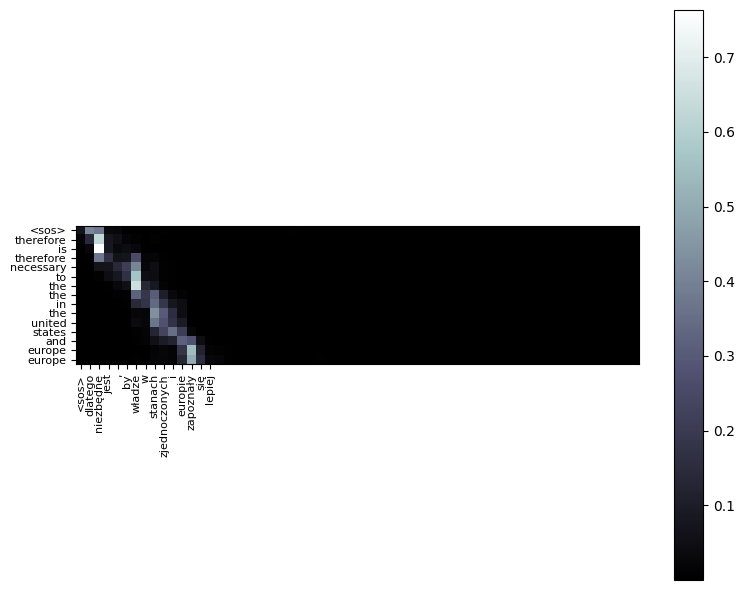

In [139]:
# plot_attention
def plot_attention(sentence, translation, attention):
    fig, ax = plt.subplots(figsize=(8, 6)) 
    attention = attention.squeeze(1).numpy() 
    cax = ax.matshow(attention, cmap="bone")  
    fig.colorbar(cax)  
    
    ax.set_xticks(range(len(sentence)))
    ax.set_yticks(range(len(translation)))
    ax.set_xticklabels(sentence, rotation=90, fontsize=10)
    ax.set_yticklabels(translation, fontsize=10)
    
    ax.xaxis.set_ticks_position('bottom')
    ax.tick_params(axis='both', which='major', labelsize=8) 
    plt.tight_layout()
    plt.show()


max_tokens = 15
short_sentence_tokens = sentence_tokens[:max_tokens]
short_translation = translation[:max_tokens]
short_attention = attention[:max_tokens, :max_tokens]

plot_attention(short_sentence_tokens, short_translation, short_attention)

### Зміни, внесені для оптимізації процесу навчання:

Зменшення розміру батчу до 16: це було зроблено для уникнення помилок через недостатню пам’ять під час навчання.
Зменшення розміру датасету: з 600,000 до 10,000 прикладів, що суттєво прискорило процес навчання та тестування, проте потенційно обмежило загальну здатність моделі до узагальнення.

### Результати навчання моделі:
На п’ятій епосі модель досягла таких метрик:

* Train Loss: 3.598
* Test Loss: 5.145

Подальше навчання не призводило до покращення продуктивності, що вказує на можливе перенавчання чи проблеми з обраними гіперпараметрами.

### Рекомендації щодо покращення:

* Збільшення обсягу навчальних даних: Використання більшого підмножини датасету (наприклад, 50,000 прикладів) може покращити узагальнення моделі.
* Тюнінг гіперпараметрів:
* * Збільшити розмір прихованих шарів (hidden size) в енкодері/декодері.
* * Експериментувати зі швидкістю навчання (learning rate).
* * Застосування регуляризації: Dropout або інші методи можуть запобігти перенавчанню.
* Поглиблений аналіз уваги: Перевірити, чи модель правильно розпізнає ключові слова для перекладу, і внести корективи в архітектуру.

### Висновки:

* Незважаючи на зменшений обсяг даних і обмежені ресурси, модель Seq2Seq показала здатність до навчання та перекладу.
* Збереження стабільних показників втрат після п’ятої епохи свідчить про те, що модель досягла свого максимуму за поточних умов.
* Для покращення результатів доцільно змінити гіперпараметри та збільшити обсяг даних.